In [1]:
%matplotlib inline
import os
import shutil
from glob import glob

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [2]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
try:
    cluster
    client
except:
    cluster = NCARCluster(memory='100 GB')
    cluster.scale(32)
    client = Client(cluster) # Connect this local process to remote workers'
client

Client Scheduler: tcp://10.12.205.200:43343 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


1pt5degC: 18 files
1pt5degC_OS: 14 files


/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 14
  **blockwise_kwargs,
/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 14
  **blockwise_kwargs,
/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 14
  **blockwise_kwargs,
/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 14
  **blockwise_kwargs,
/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 14
  **blockwise_kwargs,
/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/dask/array/co

2pt0degC: 15 files


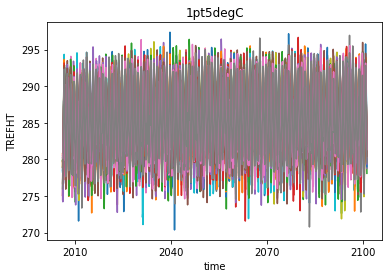

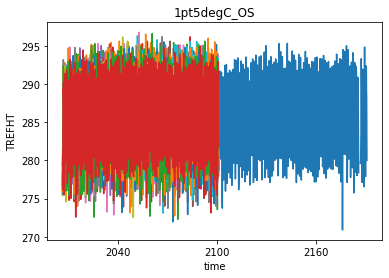

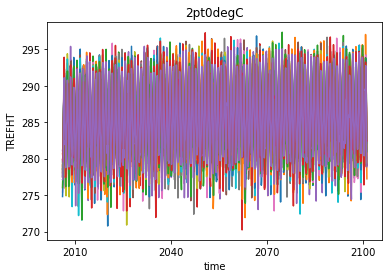

In [8]:
path = '/glade/campaign/cgd/oce/people/mclong/CESM-CAM5-BGC-LowWarming/atm/proc/tseries/monthly'
varname = 'TREFHT'
cases = [
    '1pt5degC',
    '1pt5degC_OS',
    '2pt0degC',
]

lon, lat = 5.85573, 52.0407254

for case in cases:
    
    files = sorted(glob(f'{path}/{varname}/b.e11.BRCP26C5CNBDRD.f09_g16.{case}.*.nc'))
    print(f'{case}: {len(files)} files')
    ds_list = []
    for f in files:
        ds_list.append(
            xr.open_dataset(
                f, chunks={'time': 365*5}, decode_times=True,
            )
        )

    member_id = xr.DataArray(np.arange(len(ds_list)), dims=('member_id'), name='member_id')
    ds = xr.concat(ds_list, dim=member_id)

    dsp = ds.interp(lat=lat, lon=lon).reset_coords(['lat', 'lon'], drop=True)
    dsp_mon = dsp.resample(time='M').mean()
    
    plt.figure()
    for member_id in dsp.member_id.values:
        dsp_mon.TREFHT.sel(member_id=member_id).plot()
    plt.title(case)
    
    for member_id in dsp.member_id.values:
        dsp.TREFHT.sel(member_id=member_id).to_dataframe().to_csv(f'data/cesm-commitment.{case}.TREFHT.{member_id:03d}.csv')        